# Random Effect Logistic Regression by MLMC Variational Bayes

## Model Description

##### Random Effect Models:
For $n=1,2,...$,
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Z_n \sim N(0,\tau^2)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t})}\right)$
<br>
for $t=1, ..., T$. This model carries out dimentionality reduction of binary observations $y_{n,k}$'s. Here, the dimention of $\beta$ and $x_{n,t}$ is $D$.<br>
As variational approximation of the posterior $p(z_n|y_n)$, we use $q(z_n)= N(z_n;\mu_n, \sigma_n^2)$.

To constrain the parameter $\tau^2>0$, we parametrize $\tau^2$ as $\tau^2 = \mathrm{softplus}(\alpha)$, where $\mathrm{softplus}(x) := \log(1+\exp(x))>0$.

##### Possible Extension:

By adding $\bar x_n=\frac{1}{T}\sum_t x_{n,t}$ to the predictors as 
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t}- \gamma\bar x_n)}\right)$,
<br>
we can obtain correlated random effect models.

#### We do not consider the use of Renyi divergences

## Import Packages

In [1]:
# Turn GPUs off
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm
from matplotlib import pyplot as plt
import time
import datetime
np.random.seed(0)

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## Utilities

In [4]:
sigmoid = lambda x: 1/(1+np.exp(-x))
softplus = lambda x: np.log(1+np.exp(x))
as_tf_float = lambda x: tf.cast(x, tf.float64)

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

def timestamp():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d%H%M%S")  

## Generate Toy Dataset

In [5]:
N = 1000
D = 3
T = 2

In [6]:
# Paramters
alpha = np.float64(1.)
beta0 = np.float64(0.)
beta  = np.array([0.25, 0.50, 0.75]) #np.random.randn(D) / np.sqrt(D)
param0 = {
    'alpha': alpha,
    'beta0': beta0,
    'beta': beta
}

To constrain the parameter $\tau^2>0$, we parametrize $\tau^2$ as $\tau^2 = \mathrm{softplus}(\alpha)$, where $\mathrm{softplus}(x) := \log(1+\exp(x))>0$.

In [7]:
# We assume that we have infinite amount of data.
# Thus, generator of the data is implemented.
def generate_data(N, D, T, beta0, beta, alpha):
    """
    Genarate N samples of data from the model with parameter [beta0, beta, alpha]. 
    Returns:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    z: 1-d array of size [n_MC, N]
    """

    z = np.random.randn(N) * softplus(alpha)**(1/2.)
    x = np.random.randn(N*T*D).reshape([N,T,D])
    y = bernoulli(p=sigmoid(beta0+x@beta+z.reshape([N,1]))).rvs()
    return x,y,z

## Sigmoid Normal Integral Approximation of Evidence

Ref: Barber Bishop(1998), PRML(2006)

Sigmoid normal integral approximation is:
$$\int \sigma(z + \mu)N(z;0,\tau^2)\mathrm{d}z 
\approx \sigma(\kappa \mu) \ \ \ 
\text{where}\ \ \ 
\kappa = \left(\frac{1}{1 + \pi\tau^2/8}\right)^{\frac{1}{2}}$$
This is applied to the probability of y: 
$$Pr(Y=1|X=x) = \int \sigma(z + \beta_0 + \beta^T x)N(z;0,\tau^2)\mathrm{d}z,$$
where $\tau^2 = \mathrm{softmax}(\alpha)$.

In [8]:
def sigmoid_normal_prob(x, beta0, beta, alpha):
    # Compute p(Y=1|X=x) for N samples of x_n
    N, T, D  = x.shape
    kappa = 1 / (1 + np.pi*tf.math.softplus(alpha)/8)**(1/2)
    return tf.math.sigmoid( kappa * (beta0 + tf.reshape( x@tf.reshape(beta, [D,1]), [N, T])) )

In [9]:
def sigmoid_normal_likelihood(x, y, beta0, beta, alpha):
    # Compute log p(Y=y|X=x) for N samples of (x_n, y_n) and sum them up
    pred_prob = sigmoid_normal_prob(x, beta0, beta, alpha)
    score = tf.reduce_mean(tf.reduce_sum(
        tf.math.log(pred_prob)*y + tf.math.log(1-pred_prob)*(1-y), 
        axis=1))
    return score

## Laplace Approximation of Posterior

Laplace approximation of $p(z|x,y)$ is:
$$p(z|x,y) \approx \exp\left[\frac{1}{2}\left(\frac{\mathrm{d}^2}{\mathrm{d}z^2}\log p(\hat z|x,y) \right)(z - \hat z)^2 + \text{const.}\right] = N\left(z;\hat z, \left(-\frac{\mathrm{d}^2}{\mathrm{d}z^2}\log p(\hat z|x,y) \right)^{-1}\right),$$
where $\hat z$ is the maximum a postriori (MAP), so that $\hat z = \arg\max_{z}\log p(z|x,y) = \arg\max_{z}\log p(x,y|z)p(z)$

In [10]:
def laplace_approx(x, y, beta0, beta, alpha):
    """
    Compute the mean and the varince of the 
    Laplace approximation of p(z|x,y) for each sample point.
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
     
    Returns:
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
    """
    
    N, T, D  = x.shape
    z = np.zeros([N, 1])
    _sig = lambda z: sigmoid( z + beta0 + x@beta )
    
    # Newton optimization to calculate the MAP of z|x,y
    for i in range(10):
        sig = _sig(z)
        hessian = 1/softplus(alpha) + np.sum( sig*(1-sig), axis=1, keepdims=True)
        grad    = z/softplus(alpha) + np.sum( sig - y,     axis=1, keepdims=True)
        z -= grad / hessian
        
    mu = z.reshape([N])
    sigma = (1 / hessian).reshape([N])**(1/2)
    return mu, sigma

## IW-ELBO approximation of Evidence

Importance weighted evidence lower bound (IW-ELBO) is an approximation of the evidence, and its Monte Carlo estimator is defined as:
$$\mathrm{IW}\text{-}\mathrm{ELBO}(x,z_{1:K}):=\frac{1}{N}\sum_{n=1}^{N}\log \frac{1}{K}\sum_{k=1}^{K}\left(\frac{p(x_n,z_{nk})}{q(z_{nk};x_n)}\right),$$
where $z_{nk}$ is sampled as $z_{nk}\sim q(z;x_n)$.

In [11]:
def pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma):
    """
    Compute IWELBOs using n_MC inner Monte Carlo samples of Z's at each sample point. 
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    z: 1-d array of size [n_MC, N]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
     
    Returns:
    iwelbos: 1-d array of size [N]
    """

    (N, T, D), (n_MC, n) = x.shape, z.shape
    y = as_tf_float( tf.reshape(y, [1,N,T]) )
    mu = tf.reshape(mu, [1,N])
    sigma = tf.reshape(sigma, [1,N])
    
    y_logits = tf.convert_to_tensor( beta0\
                                    + tf.reshape( x@tf.reshape(beta, [D,1]), [1, N, T])\
                                    + tf.reshape(z, [n_MC, N, 1]) 
                                   )
    p_y = tfp.distributions.Bernoulli(logits=y_logits)
    p_z = tfp.distributions.Normal(loc=np.zeros([1, N]), scale=tf.math.softplus(alpha)**(1/2.))
    q_z = tfp.distributions.Normal(loc=mu, scale=sigma)
    
    log_prob_ratio = \
        tf.reduce_sum( p_y.log_prob(y), axis=2)\
        + p_z.log_prob(z)\
        - q_z.log_prob(z)
    
    iwelbos = tf_logmeanexp(log_prob_ratio, axis=0)
    return iwelbos

In [12]:
def IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC):
    """
    Compute IWELBO
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
     
    Returns:
    iwelbo: scalar value of average of iwelbo's at each sample point.
    """

    N, = mu.shape
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    iwelbo = tf.reduce_mean( pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma) )
    return iwelbo

## MLMC

In [13]:
def pointwise_dIWELBO(x, y, z, beta0, beta, alpha, mu, sigma):
    """
    Compute the coupled differences of IWELBO's at each sample point.
    Differences between "IWELBO with n_MC inner Monte Carlo samples" 
    and "IWELBO with n_MC/2 inner Monte Carlo samples" are taken.
    
    Note that difference is not taken when n_MC = 1. 
    In that case, IWELBO with n_MC = 1 is Evaluated.
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    z: 1-d array of size [n_MC, N]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of [N]
    sigma: 1-d array of [N]
     
    Returns:
    scores: 1-d array of size [N]
    """
    
    (N, T, D), (n_MC, N) = x.shape, z.shape
    assert np.log2(n_MC)%1==0
    
    if n_MC == 1:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma)
    else:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[:n_MC//2 ], beta0, beta, alpha, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[ n_MC//2:], beta0, beta, alpha, mu, sigma)
    return scores

In [14]:
def dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level):
    """
    Compute average of the coupled differences of IWELBO's with n_MC.
    Differences between "IWELBO with n_MC inner Monte Carlo samples" 
    and "IWELBO with n_MC/2 inner Monte Carlo samples" are taken.
    
    Note that difference is not taken when n_MC = 1. 
    In that case, average IWELBO with n_MC = 1 is Evaluated.
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
     
    Returns:
    score: scalar value of average of differnece of iwelbo's at each sample point (except when n_MC=1).
    """

    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    score = tf.reduce_mean( pointwise_dIWELBO(x, y, z, beta0, beta, alpha, mu, sigma) )
    return score

In [15]:
def IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=8, w0=1-2.**(-3/2), b=2, randomize=False):
    """
    Compute IWELBO by MLMC
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
    max_level: integer
    w0: the proportion of total samples in (x,y) used at the level 0.
        in other words, 100*(1-w0) % of the total samples are used for estimating the correction term.
    b: scalar. the second moment of the coupled difference estimator (dIWELBO) must decrease at a rate of O(2^(-b*level)).
    randomize: whether to use randomization of MLMC.
    
    Returns:
    iwelbo: scalar estimate of average iwelbo over sample points.
    """
    
    N, T, D = x.shape
    
    # determine proportions of the number of smaples among levels
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        weights = 2.**(-(b+1)/2*np.arange(max_level))
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
        levels = np.arange(max_level+1)
    
    # determine the N_l's
    if randomize==True:
        Ns = np.random.multinomial(n=N, pvals=weights)    
    elif randomize==False:
        Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
        Ns[0] = N - sum(Ns[1:])
    else:
        raise(Exception("Invarid argument for 'randomize' of function IWELBO_MLMC. It must be True or False."))
    
    # compute dIWELBO's using disjoint samples at each level and sum them up
    offset = 0
    iwelbo = 0
    for i, l in enumerate(levels):
        if Ns[i]==0:
            continue
        x_tmp = x[offset:offset+Ns[i]]
        y_tmp = y[offset:offset+Ns[i]]
        mu_tmp = mu[offset:offset+Ns[i]]
        sigma_tmp = sigma[offset:offset+Ns[i]]
                       
        if randomize==True:
            iwelbo += dIWELBO(x_tmp, y_tmp, beta0, beta, alpha, mu_tmp, sigma_tmp, level=l) * Ns[i] / N / weights[i]   
        elif randomize==False:
            iwelbo += dIWELBO(x_tmp, y_tmp, beta0, beta, alpha, mu_tmp, sigma_tmp, level=l)
        
        offset += Ns[i]
    
    return iwelbo

## SUMO

#### Variance Analysis of SUMO:
We assume that $\mathbb{P}(k\leq\mathcal{K})=\frac{1}{k}$ for $\mathcal{K}\leq K_{\text{max}}$, and accordingly, $\mathbb{P}(k\leq\mathcal{K})=\frac{1}{k(k+1)}$. Also, we know convergence rate of $\Delta_k:=\mathrm{IWELBO(x,z_{1:k})} - \mathrm{IWELBO(x,z_{1:k-1})}$ is as following:

- $\mathrm{E}|\Delta_k| = \mathcal{O}(1/k)$
- $\mathrm{E}|\Delta_k|^2 = \mathcal{O}(1/k^2) \geq \mathrm{Var}[\Delta_k]$
- $\mathrm{E}[\Delta_k] = \mathcal{O}(1/k^2)$　　　←（∵$\sum_{k=K}^{\infty}\mathrm{E}[\Delta_k] = \mathcal{O}(\frac{1}{K})$）

Using above properties, we can analyze the order of magnitude of the variance of SUMO as:
\begin{align}
\mathrm{Var}[\Delta SUMO]
&= \mathrm{Var}_{\mathcal{K}, \Delta_{1:K_{\text{max}}}} 
\left( \sum_{k=1}^{K_{\text{max}}} \frac { \mathbb{1}_{(k\leq\mathcal{K})} } 
{ \mathbb{P}(k\leq\mathcal{K}) } \Delta_k \right) \\
&= \mathrm{E}_{\mathcal{K}}\mathrm{Var}_{\Delta_{1:K_{\text{max}}}}
\left( \sum_{k=1}^{\mathcal{K}} k \Delta_k | \mathcal {K}\right)
 + \mathrm{Var}_{\mathcal{K}}\mathrm{E}_{\Delta_{1:K_{\text{max}}}}
\left( \sum_{k=1}^{\mathcal{K}} k \Delta_k | \mathcal {K}\right) \\
&= \mathrm{E}_{\mathcal{K}}\sum_{k=1}^{\mathcal{K}} k^2 \mathrm{Var}_{\Delta_{1:K_{\text{max}}}}
\left( \Delta_k | \mathcal {K}\right)
 + \mathrm{Var}_{\mathcal{K}} \sum_{k=1}^{\mathcal{K}} k \mathrm{E}_{\Delta_{1:K_{\text{max}}}}
\left( \Delta_k | \mathcal {K}\right) \\
&= \mathrm{E}_{\mathcal{K}}\sum_{k=1}^{\mathcal{K}} k^2 \mathcal{O}(1/k^2)
 + \mathrm{Var}_{\mathcal{K}} \sum_{k=1}^{\mathcal{K}} k \mathcal{O}(1/k^2) \\
&= \mathrm{E}_{\mathcal{K}} \mathcal{O}(\mathcal{K})
 + \mathrm{Var}_{\mathcal{K}}\mathcal{O}(\log \mathcal{K}) \\
&= \mathcal{O}(\log K_{\text{max}}) + \text{const.}
\end{align}

Note that the expected complexity of SUMO is $\mathrm{E}[\mathcal{\mathcal{K}}] = \mathcal{O}(\log K_{\text{max}})$. Therefore, the "variance per reciprocal complexity" for SUMO is $\mathcal{O}\left((\log K_{\text{max}})^2\right)$. Those for NMC and MLMC are $\mathcal{O}(K_{\text{max}})$ and $\mathcal{O}(1)$ respectively.

In [16]:
def conditional_IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K):
    """
    Compute IWELBO by SUMO for one sample point, given K
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
    K: integer 
    
    Returns:
    iwelbo: scalar estimate of iwelbo at the given sample point.
    """
    N,T,D = x.shape
    z = tf.random.normal(mean=mu, stddev=sigma, shape=[K,N], dtype=tf.float64)

    # compute prob ratio of shape [K,N]
    y_logit = beta0 + tf.reshape( x @ tf.reshape(beta,[D,1]), [1,N,T] ) + tf.reshape(z,[K,N,1]) 
    p_y = tfp.distributions.Bernoulli(logits=y_logit)
    p_z = tfp.distributions.Normal(loc=0, scale=tf.math.softplus(alpha)**(1/2.))
    q_z = tfp.distributions.Normal(loc=mu, scale=sigma)
    
    log_prob_ratio = \
        tf.reduce_sum( p_y.log_prob(y), axis=2)\
        + p_z.log_prob(z)\
        - q_z.log_prob(z)
    
    # compute SUMO est.
    ks = tf.reshape( tf.cast( tf.range(0,K) + 1, tf.float64), [K,1])
    cum_iwelbo = tf.math.cumulative_logsumexp(log_prob_ratio, axis=0) - tf.math.log(ks)
    inv_weights = ks
    iwelbo = cum_iwelbo[0,:] + tf.reduce_sum(inv_weights[1:] * (cum_iwelbo[1:] - cum_iwelbo[:K-1]), axis=0)
    
    return iwelbo

In [17]:
def IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=64):
    """
    Compute IWELBO by MLMC
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    beta0: scalar
    beta: 1-d array of size [D]
    alpha: scalar
    mu: 1-d array of size [N]
    sigma: 1-d array of size [N]
    K_max: integer 
    
    Returns:
    iwelbo: scalar estimate of average iwelbo over sample points.
    """
    
    N,T,D = x.shape
    
    Us = tf.random.uniform(shape=[N], dtype=tf.float64)
    Ks = tf.minimum(1/Us, tf.cast(K_max, tf.float64))
    Ks = tf.cast(tf.math.floor(Ks), tf.int64)
    unique, _, counts =  tf.unique_with_counts(tf.sort(Ks))
    
    offset = 0
    iwelbo = 0
    for K, cnt in zip(unique, counts):
        x_tmp = x[offset:offset+cnt]
        y_tmp = y[offset:offset+cnt]
        mu_tmp = mu[offset:offset+cnt]
        sigma_tmp = sigma[offset:offset+cnt]
        iwelbo += (1/N) * tf.reduce_sum( conditional_IWELBO_SUMO(x_tmp, y_tmp, beta0, beta, alpha, mu_tmp, sigma_tmp, K) ) 
        offset += cnt
    
    return iwelbo

## Make sure that implementations are consistent

In [18]:
x,y,_ = generate_data(N=10000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    

In [19]:
signorm_likelihood = sigmoid_normal_likelihood(x, y, beta0, beta, alpha).numpy()
elbo_likelihood = IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=1).numpy()
iwelbo_likelihood = IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=64).numpy()
iwelbo_likelihood_mlmc = IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=6, w0=0.9, randomize=False).numpy()
iwelbo_likelihood_randmlmc = IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=6, w0=0.9, randomize=True).numpy()
iwelbo_likelihood_sumo = IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=10000).numpy()

In [20]:
signorm_likelihood, elbo_likelihood, iwelbo_likelihood

(-1.269810829237006, -1.2563443239323726, -1.254344334208579)

In [21]:
iwelbo_likelihood_mlmc, iwelbo_likelihood_randmlmc, iwelbo_likelihood_sumo 

(-1.254311662482896, -1.258285240630745, -1.2529900953879132)

## MLMC codition check for objective

In [22]:
def conv_stats_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=1):
    # Compute dIWELBO (and IWELBO) for each sample and 
    # summarize them into several statistics.

    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, alpha, mu, sigma).numpy()
    iwelbos = pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma).numpy()
    
    return {'mean_dIWELBO':np.mean(diwelbos), 
            'mean_abs_dIWELBO':np.mean(np.abs(diwelbos)), 
            'mean_squared_dIWELBO':np.mean(diwelbos**2),
            'var_dIWELBO':np.var(diwelbos), 
            'var_IWELBO':np.var(iwelbos)}

In [23]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    return conv_stats_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=l)
L=13
conv_stats = [tmp(l) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

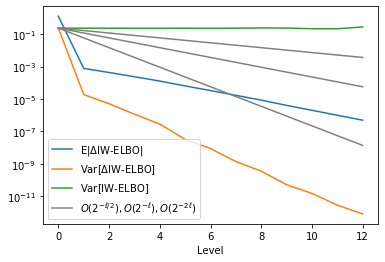

In [24]:
# plot results
plt.plot(conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO', 'var_IWELBO']])

# plot O(2^{-l/2}), O(2^{-l}), O(2^{-2l})
s,t = conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO']].iloc[0]
plt.plot(t*2.**(-np.arange(L)/2), c='grey')
plt.plot(t*2.**(-np.arange(L)), c='grey')
plt.plot(t*2.**(-np.arange(L)*2), c='grey')

plt.legend([r'$\mathrm{E} | \Delta \mathrm{IW}$-$\mathrm{ELBO}|$', 
            r'$\mathrm{Var}[\Delta \mathrm{IW}$-$\mathrm{ELBO}]$', 
            r'$\mathrm{Var}[\mathrm{IW}$-$\mathrm{ELBO}]$',
            r'$O(2^{-\ell/2}), O(2^{-\ell}), O(2^{-2\ell})$'])
plt.xlabel('Level')
plt.yscale('log')

In [25]:
# compute cost-variance efficiency of MLMC 
C = [1 if l==0 else 2**(l+1) for l in range(L)]
V = conv_stats['var_dIWELBO']
N = np.sqrt(V/C)
cost_mlmc = [np.sum([np.sqrt(c*v) for c,v in zip(C[:l+1], V[:l+1])])**2  for l in range(L)]
cost_nmc = [2**l * v for l,v in enumerate(conv_stats['var_IWELBO'])]

(Theoretical) Variance per Reciprocal Complexity and N_l's for MLMC


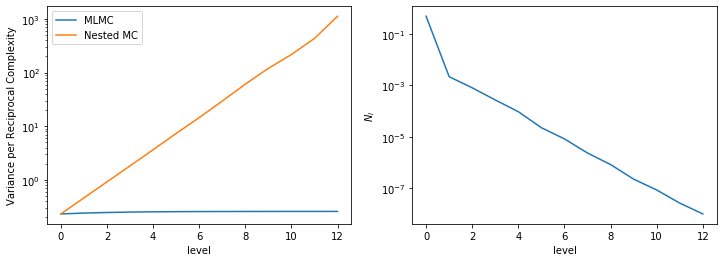

In [26]:
plt.figure(figsize=[12,4])
# plot theoretical computational efficiency
plt.subplot(1,2,1)
plt.plot(cost_mlmc)
plt.plot(cost_nmc)
plt.yscale('log')
plt.ylabel('Variance per Reciprocal Complexity')
plt.xlabel('level')
plt.legend(['MLMC', 'Nested MC'])
# plot N_l's for MLMC
plt.subplot(1,2,2)
plt.plot(N)
plt.yscale('log')
plt.ylabel(r'$N_l$')
plt.xlabel('level')
print('(Theoretical) Variance per Reciprocal Complexity and N_l\'s for MLMC')

In [27]:
conv_stats

,mean_dIWELBO,mean_abs_dIWELBO,mean_squared_dIWELBO,var_dIWELBO,var_IWELBO
0,-1.252914e+00,1.252959e+00,1.801901e+00,2.321084e-01,0.232108
1,7.659012e-04,7.659012e-04,1.928202e-05,1.869541e-05,0.230994
2,4.296648e-04,4.296648e-04,5.297300e-06,5.112689e-06,0.229762
3,2.353968e-04,2.353968e-04,1.215908e-06,1.160497e-06,0.228204
4,1.272100e-04,1.272100e-04,3.021725e-07,2.859902e-07,0.228002
5,6.391666e-05,6.391666e-05,3.656841e-08,3.248307e-08,0.229570
6,3.313349e-05,3.313349e-05,9.886079e-09,8.788250e-09,0.226590
7,1.687736e-05,1.687736e-05,1.686501e-09,1.401656e-09,0.230252
8,8.531222e-06,8.531222e-06,4.300854e-10,3.573037e-10,0.238437
9,4.047158e-06,4.047158e-06,6.894719e-11,5.256771e-11,0.235069


## MLMC codition check for gradients

In [48]:
def conv_stats_grad_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=1):
    # Compute the gradient of dIWELBO (and IWELBO) for each sample and 
    # summarize them into several statistics.

    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N]).T
    
    param = tf.concat([beta, [beta0], [alpha]], axis=0)
    param = tf.Variable(param, dtype=tf.float64)
    params = tf.reshape(param, [1,D+2]) * np.ones([N,1])

    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)        
    
    # Define a gradient function to be vectorized (vectorization for better performance)
    def get_grad(args):
        # get gradient of dIWELBO (and IWELBO) given one sample
        param, x_, y_, z_, mu, sigma = args
        z_ = tf.reshape(z_, [-1,1])
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[0,:D]
            beta0_ = param[0,D]
            alpha_ = param[0,D+1]
            diwelbos = pointwise_dIWELBO(x_, y_, z_, beta0_, beta_, alpha_, mu, sigma)
            iwelbos = pointwise_IWELBO(x_, y_, z_, beta0_, beta_, alpha_, mu, sigma)    
        a = g.gradient(diwelbos, param)
        b = g.gradient(iwelbos, param)
        del g
        return a,b
    
    # Compute the gradient of dIWELBO (and IWELBO) for each sample
    args = [tf.expand_dims(arg, axis=1) for arg in [params, x, y, z, mu, sigma]]
    grads = tf.vectorized_map(get_grad, args)
    
    grad_diwelbos = tf.squeeze(grads[0])#[:D+1]
    grad_iwelbos = tf.squeeze(grads[1])#[:D+1]
    
    # return summary statistics of the gradients
    return {'norm_mean_grad_dIWELBO': np.linalg.norm(np.mean(grad_diwelbos, axis=0)), 
            'mean_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)), 
            'mean_squared_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)**2),
            'trace_covariance_grad_dIWELBO': np.sum(np.var(grad_diwelbos, axis=0)), 
            'trace_covariance_grad_IWELBO': np.sum(np.var(grad_iwelbos, axis=0))}

In [49]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    return conv_stats_grad_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=l)
L=13
conv_stats = [tmp(l) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

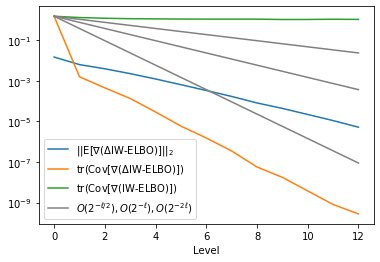

In [50]:
# plot results
plt.plot(conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO', 'trace_covariance_grad_IWELBO']])

# plot O(2^{-l/2}), O(2^{-l}), O(2^{-2l})
s,t = conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO']].iloc[0]
plt.plot(t*2.**(-np.arange(L)/2), c='grey')
plt.plot(t*2.**(-np.arange(L)), c='grey')
plt.plot(t*2.**(-np.arange(L)*2), c='grey')

plt.legend([r'$||\mathrm{E} [\nabla (\Delta \mathrm{IW}$-$\mathrm{ELBO})]||_2$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\nabla(\Delta \mathrm{IW}$-$\mathrm{ELBO})])$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\nabla(\mathrm{IW}$-$\mathrm{ELBO})])$',
            r'$O(2^{-\ell/2}), O(2^{-\ell}), O(2^{-2\ell})$'])
plt.xlabel('Level')
plt.yscale('log')

In [52]:
# compute cost-variance efficiency of MLMC 
C = [1 if l==0 else 2**(l+1) for l in range(L)]
V = conv_stats['trace_covariance_grad_dIWELBO']
N = np.sqrt(V/C)
cost_mlmc = [np.sum([np.sqrt(c*v) for c,v in zip(C[:l+1], V[:l+1])])**2  for l in range(L)]
cost_nmc = [2**l * v for l,v in enumerate(conv_stats['trace_covariance_grad_IWELBO'])]

(Theoretical) Variance per Reciprocal Complexity and N_l's for MLMC


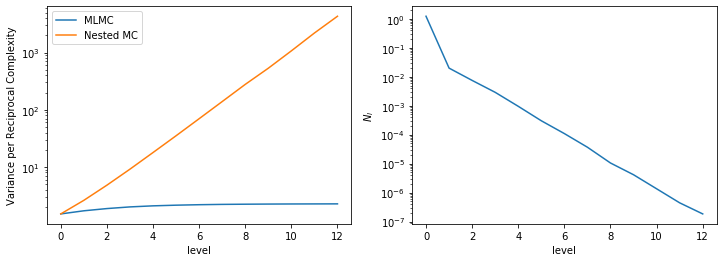

In [53]:
plt.figure(figsize=[12,4])
# plot theoretical computational efficiency
plt.subplot(1,2,1)
plt.plot(cost_mlmc)
plt.plot(cost_nmc)
plt.yscale('log')
plt.ylabel('Variance per Reciprocal Complexity')
plt.xlabel('level')
plt.legend(['MLMC', 'Nested MC'])
# plot N_l's for MLMC
plt.subplot(1,2,2)
plt.plot(N)
plt.yscale('log')
plt.ylabel(r'$N_l$')
plt.xlabel('level')
print('(Theoretical) Variance per Reciprocal Complexity and N_l\'s for MLMC')

In [54]:
conv_stats

,norm_mean_grad_dIWELBO,mean_norm_grad_dIWELBO,mean_squared_norm_grad_dIWELBO,trace_covariance_grad_dIWELBO,trace_covariance_grad_IWELBO
0,0.014784,1.101125,1.507883e+00,1.507664e+00,1.507664
1,0.006279,0.012240,1.624828e-03,1.585405e-03,1.302954
2,0.003917,0.006958,4.644372e-04,4.490930e-04,1.199311
3,0.002257,0.003835,1.404026e-04,1.353086e-04,1.143088
4,0.001231,0.002039,3.083981e-05,2.932469e-05,1.116475
5,0.000645,0.001071,6.316357e-06,5.900531e-06,1.097129
6,0.000335,0.000553,1.651149e-06,1.539144e-06,1.090118
7,0.000171,0.000279,3.810207e-07,3.519311e-07,1.086937
8,0.000081,0.000136,6.410991e-08,5.748013e-08,1.085550
9,0.000044,0.000072,1.969918e-08,1.777097e-08,1.040809


In [32]:
def conv_stats_dSUMO(x, y, beta0, beta, alpha, mu, sigma, level=1):
    # Compute dIWELBO (and IWELBO) for each sample and 
    # summarize them into several statistics.

    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    dsumos = 0
    dsumos += pointwise_IWELBO(x, y, z[ :,:], beta0, beta, alpha, mu, sigma).numpy()
    dsumos -= pointwise_IWELBO(x, y, z[1:,:], beta0, beta, alpha, mu, sigma).numpy()
    
    dN = N//10
    var_sumos = dN * np.var([
        IWELBO_SUMO(
            x[dN*i:dN*(i+1)], y[dN*i:dN*(i+1)], beta0, beta, alpha,
            mu[dN*i:dN*(i+1)], sigma[dN*i:dN*(i+1)], K_max=2**level
            ) 
        for i in range(10)])
    
    return {'mean_dSUMO':np.mean(dsumos), 
            'mean_abs_dSUMO':np.mean(np.abs(dsumos)), 
            'mean_squared_dSUMO':np.mean(dsumos**2),
            'var_dSUMO':np.var(dsumos),
            'var_SUMO':var_sumos}

In [33]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    return conv_stats_dSUMO(x, y, beta0, beta, alpha, mu, sigma, level=l)
L=13
conv_stats = [tmp(l) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

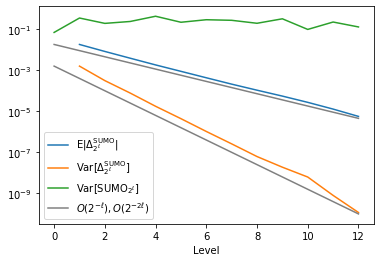

In [34]:
# plot results
plt.plot(conv_stats[['mean_abs_dSUMO', 'var_dSUMO', 'var_SUMO']])

# plot O(2^{-l/2}), O(2^{-l}), O(2^{-2l})
s,t = conv_stats[['mean_abs_dSUMO', 'var_dSUMO']].iloc[1]
plt.plot(s*2.**(-np.arange(L)), c='grey')
plt.plot(t*2.**(-np.arange(L)*2), c='grey')

plt.legend([r'$\mathrm{E}  |\Delta^{\mathrm{SUMO}}_{2^{\ell}}|$', 
            r'$\mathrm{Var}[\Delta^{\mathrm{SUMO}}_{2^{\ell}}]$', 
            r'$\mathrm{Var}[\mathrm{SUMO}_{2^{\ell}}]$', 
            r'$O(2^{-\ell}), O(2^{-2\ell})$'])
plt.xlabel('Level')
plt.yscale('log')

In [35]:
conv_stats

,mean_dSUMO,mean_abs_dSUMO,mean_squared_dSUMO,var_dSUMO,var_SUMO
0,NaN,NaN,NaN,NaN,0.068968
1,0.000740,0.017782,1.553683e-03,1.553136e-03,0.348702
2,0.000129,0.008097,3.037143e-04,3.036977e-04,0.190705
3,0.000059,0.003783,7.484165e-05,7.483813e-05,0.236357
4,0.000003,0.001778,1.691366e-05,1.691365e-05,0.425870
5,0.000005,0.000863,4.194253e-06,4.194232e-06,0.216465
6,-0.000002,0.000419,9.931095e-07,9.931054e-07,0.287614
7,-0.000002,0.000204,2.459470e-07,2.459445e-07,0.269569
8,0.000001,0.000103,5.897989e-08,5.897804e-08,0.192972
9,0.000001,0.000053,1.779784e-08,1.779584e-08,0.319300


## Cost comparison of objective

In [55]:
L = 13
objectives = {
    'NMC':      lambda x,y,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC':     lambda x,y,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.99, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.99, b=1.8, randomize=True),
    'SUMO':     lambda x,y,mu,sigma,level: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=2**level)
}
results = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( obj(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        if level>10 and name=='NMC':
            start = time.time()
            obj(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            obj(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

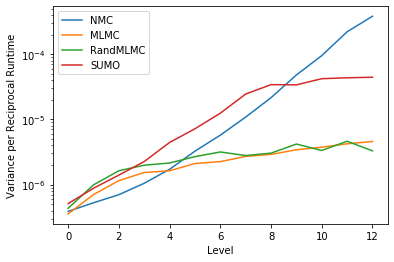

In [56]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel('Variance per Reciprocal Runtime')
plt.yscale('log')

Variance per "reciprocal of the runtime" is considered because the varince is propotional to the  "reciprocal of the runtime". As we increase the computational complexity (runtime), the decrease in varince is inversely propotional to the complexity. 

## Cost comparison of gradients

In [59]:
L = 13
objectives = {
    'NMC':      lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.99, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.99, b=1.8, randomize=True),
    'SUMO':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=2**level)
}

def d(f):
    # return the derivative of f
    # returned value is a function
    def df(x,y,mu,sigma,level):
        param = tf.concat([beta, [beta0], [alpha]], axis=0)
        param = tf.Variable(param, dtype=tf.float64)
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[:D]
            beta0_ = param[D]
            alpha_ = param[D+1]
            target = f(x,y,beta0_,beta_,alpha_,mu,sigma,level)
        est = g.gradient(target, param)
        return est
    return df

results = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( d(obj)(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        # Avoid the memery runout by 
        # manipulating the case of NMC with large n_MC (large level)
        if level>10 and name=='NMC':
            start = time.time()
            d(obj)(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            d(obj)(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

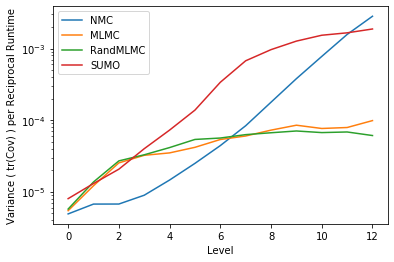

In [60]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0).sum(axis=1) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel(r'Variance ( tr(Cov) ) per Reciprocal Runtime')
plt.yscale('log')

In [63]:
L = 13
objectives = {
    'NMC':      lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.98, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.98, b=1.8, randomize=True),
    'SUMO':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=2**level)
}

def d(f):
    # return the derivative of f
    # returned value is a function
    def df(x,y,mu,sigma,level):
        param = tf.concat([beta, [beta0], [alpha]], axis=0)
        param = tf.Variable(param, dtype=tf.float64)
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[:D]
            beta0_ = param[D]
            alpha_ = param[D+1]
            target = f(x,y,beta0_,beta_,alpha_,mu,sigma,level)
        est = g.gradient(target, param)
        return est
    return df

results = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( d(obj)(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        # Avoid the memery runout by 
        # manipulating the case of NMC with large n_MC (large level)
        if level>10 and name=='NMC':
            start = time.time()
            d(obj)(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            d(obj)(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

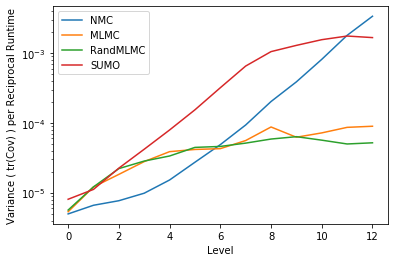

In [64]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0).sum(axis=1) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel(r'Variance ( tr(Cov) ) per Reciprocal Runtime')
plt.yscale('log')

In [ ]:
L = 13
objectives = {
    'NMC':      lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.95, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.95, b=1.8, randomize=True),
    'SUMO':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=2**level)
}

def d(f):
    # return the derivative of f
    # returned value is a function
    def df(x,y,mu,sigma,level):
        param = tf.concat([beta, [beta0], [alpha]], axis=0)
        param = tf.Variable(param, dtype=tf.float64)
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[:D]
            beta0_ = param[D]
            alpha_ = param[D+1]
            target = f(x,y,beta0_,beta_,alpha_,mu,sigma,level)
        est = g.gradient(target, param)
        return est
    return df

results = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( d(obj)(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        # Avoid the memery runout by 
        # manipulating the case of NMC with large n_MC (large level)
        if level>10 and name=='NMC':
            start = time.time()
            d(obj)(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            d(obj)(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

In [ ]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0).sum(axis=1) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel(r'Variance ( tr(Cov) ) per Reciprocal Runtime')
plt.yscale('log')

In [ ]:
L = 13
objectives = {
    'NMC':      lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.90, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.90, b=1.8, randomize=True),
    'SUMO':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=2**level)
}

def d(f):
    # return the derivative of f
    # returned value is a function
    def df(x,y,mu,sigma,level):
        param = tf.concat([beta, [beta0], [alpha]], axis=0)
        param = tf.Variable(param, dtype=tf.float64)
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[:D]
            beta0_ = param[D]
            alpha_ = param[D+1]
            target = f(x,y,beta0_,beta_,alpha_,mu,sigma,level)
        est = g.gradient(target, param)
        return est
    return df

results = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[], 'SUMO':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( d(obj)(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        # Avoid the memery runout by 
        # manipulating the case of NMC with large n_MC (large level)
        if level>10 and name=='NMC':
            start = time.time()
            d(obj)(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            d(obj)(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

In [ ]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0).sum(axis=1) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel(r'Variance ( tr(Cov) ) per Reciprocal Runtime')
plt.yscale('log')

## Maximum Likelihood by Different Approximation

In [41]:
def get_mlmc_cost(N, max_level, b, w0):
    # compute the cost of MLMC estimation 
    # when the size of x (and that of y) is N
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        weights = 2.**(-(b+1)/2*np.arange(max_level))
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
        levels = np.arange(max_level+1)
    cost = np.ceil(N * weights[0])\
            + N * sum( np.ceil(weights[1:] * (2**levels[1:] + 2**(levels[1:]-1))) )
    return cost

In [42]:
objectives = {
    "signorm":   lambda x, y, beta0, beta, alpha, mu, sigma: sigmoid_normal_likelihood(x, y, beta0, beta, alpha),
    "elbo":      lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=1),
    "iwelbo8":   lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=8),
    "iwelbo64":  lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=64),
    "iwelbo512": lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=512),
    "iwelbo512_mlmc": lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=9, w0=0.90, b=1.8, randomize=False),
    "iwelbo512_randmlmc": lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=9, w0=0.90, b=1.8, randomize=True),
    "iwelbo512_sumo": lambda x, y, beta0, beta, alpha, mu, sigma: IWELBO_SUMO(x, y, beta0, beta, alpha, mu, sigma, K_max=512),

}
N,T,D = (1000, 2, 3) if tf.test.is_gpu_available() else (200, 2, 3)

n_repeat = 10
params_repeated = {name:[] for name in objectives.keys()}

for name, obj in objectives.items():
    alpha_s = []
    beta0_s = []
    beta_s = []
    for i in range(n_repeat):
        print("training {}.... #iter:{} ".format(name,i))

        beta0_ = tf.Variable(0., dtype=tf.float64)
        beta_  = tf.Variable(np.zeros([D]), dtype=tf.float64)
        alpha_   = tf.Variable(1., dtype=tf.float64)

        # Gradient Descent
        for t in range(2001):

            rho_t = 0.5/(1+t)**0.7
            x,y,_ = generate_data(N, D, T, beta0, beta, alpha)
            # balance the cost of mlmc and nmc when level=9 (n_MC=512)
            if 'mlmc' in name:
                cost_nmc  = N * 2**9
                cost_mlmc = get_mlmc_cost(N, max_level=9, b=1.8, w0=0.9)
                N_mlmc = np.math.ceil(N * (cost_nmc / cost_mlmc))
                x,y,_ = generate_data(N_mlmc, D, T, beta0, beta, alpha)    

            with tf.GradientTape() as g:
                g.watch([beta0_, beta_, alpha_])
                mu, sigma = laplace_approx(x, y, beta0_.numpy(), beta_.numpy(), alpha_.numpy())
                score = obj(x, y, beta0_, beta_, alpha_, mu, sigma)
            dbeta0_, dbeta_, dalpha_ = g.gradient(score, [beta0_, beta_, alpha_])

            beta0_ = beta0_ + rho_t*dbeta0_
            beta_ = beta_ + rho_t*dbeta_
            alpha_ = alpha_ + dalpha_
            if t%200==0 and i==0:
                print("#iter: {},\tloss: {}".format(t, -score.numpy()))
        alpha_s.append(alpha_.numpy())
        beta0_s.append(beta0_.numpy())
        beta_s.append(beta_.numpy())
    print()
    params_repeated[name] = {
            'alpha': np.array(alpha_s),
            'beta0': np.array(beta0_s),
            'beta': np.array(beta_s)
    }

training signorm.... #iter:0 
#iter: 0,	loss: 1.3862943611198892
#iter: 200,	loss: 1.2843387479373078
#iter: 400,	loss: 1.2532343386730878
#iter: 600,	loss: 1.217510129027135
#iter: 800,	loss: 1.3085853724159608
#iter: 1000,	loss: 1.2728918446194146
#iter: 1200,	loss: 1.2460844993625715
#iter: 1400,	loss: 1.277117095367773
#iter: 1600,	loss: 1.2372123789480167
#iter: 1800,	loss: 1.3147350947135164
#iter: 2000,	loss: 1.2720743984658776
training signorm.... #iter:1 
training signorm.... #iter:2 
training signorm.... #iter:3 
training signorm.... #iter:4 
training signorm.... #iter:5 
training signorm.... #iter:6 
training signorm.... #iter:7 
training signorm.... #iter:8 
training signorm.... #iter:9 

training elbo.... #iter:0 
#iter: 0,	loss: 1.3684202891889812
#iter: 200,	loss: 1.23963932873342
#iter: 400,	loss: 1.2692193865808756
#iter: 600,	loss: 1.226427835080893
#iter: 800,	loss: 1.208051247489526
#iter: 1000,	loss: 1.2747845942767666
#iter: 1200,	loss: 1.3244548539081997
#iter: 1

In [43]:
def expand(key, val):
    # expand {"name":array([1,2,3,4,5])}
    # into {"name1":1, "name2":2, ..., "name5":5}
    if type(val)==np.ndarray:
        return {key+str(i+1): x for i,x in enumerate(val)} 
    else:
        return {key:val} 

def expand_param(param):
    expanded_param = {}
    for key, val in param.items():
        expanded_param.update(expand(key,val))
    return expanded_param

In [44]:
params = {'ground_truth': expand_param(param0)}
params['ground_truth'].update({'MSE':0})
for name in objectives.keys():
    param_repeated = params_repeated[name]
    param_mean   = expand_param({name: array.mean(axis=0) for name, array in  param_repeated.items()})
    param_var = expand_param({name: array.std(axis=0) for name, array in  param_repeated.items()})
    param = {name_:'{:.5f} ± {:.5f}'.format(mean,var**(1/2.)) 
             for name_, mean, var 
             in zip( param_mean.keys(), param_mean.values(), param_var.values() )}
    error = [var+(mean-true_mean)**2 
             for var, mean, true_mean 
             in zip( param_var.values(), param_mean.values(), params['ground_truth'].values() )]
    MSE = sum(error)
    param.update({'MSE':MSE})
    params.update({name :param})

In [45]:
data = pd.DataFrame(params).T
data

,alpha,beta0,beta1,beta2,beta3,MSE
ground_truth,1,0,0.25,0.5,0.75,0
signorm,-0.25835 ± 0.22716,0.00112 ± 0.05163,0.22098 ± 0.04554,0.44282 ± 0.04551,0.66329 ± 0.06490,1.6577
elbo,-0.39245 ± 0.57450,0.00089 ± 0.05513,0.22217 ± 0.06323,0.44297 ± 0.07027,0.66426 ± 0.09117,2.30064
iwelbo8,0.54557 ± 0.30603,0.00085 ± 0.06413,0.23542 ± 0.05654,0.47014 ± 0.05466,0.70443 ± 0.04905,0.31604
iwelbo64,0.80270 ± 0.25726,-0.00148 ± 0.05791,0.24046 ± 0.04726,0.47855 ± 0.04576,0.72200 ± 0.04750,0.116384
iwelbo512,0.92525 ± 0.17150,0.00066 ± 0.04204,0.24175 ± 0.05607,0.48067 ± 0.06059,0.72257 ± 0.05731,0.0480615
iwelbo512_mlmc,0.89110 ± 0.18162,0.00012 ± 0.02295,0.24036 ± 0.02213,0.48085 ± 0.02634,0.72142 ± 0.02813,0.0486241
iwelbo512_randmlmc,0.89647 ± 0.18381,-0.00022 ± 0.02170,0.24039 ± 0.01841,0.48070 ± 0.02559,0.72175 ± 0.02774,0.0480015
iwelbo512_sumo,1.07580 ± 0.78546,-0.00227 ± 0.07010,0.23778 ± 0.09931,0.47355 ± 0.12398,0.71156 ± 0.14687,0.676742


In [46]:
data.to_csv('../out/random_effect_logistic_regression/MLE_error_{}.csv'.format(timestamp()))

#### Bottom Line: 
- IWELBO with large number of inner MC samples gives better estiamte than ELBO or sigmoid normal integral approximation, even for this simple model. 
- MLMC is more effective than nested MC when used for maximum likelihood estimation.